In [69]:
import numpy as np
import numpy.fft as fft
import pandas as pd
from matplotlib import pyplot as plt
import datetime as dt
from math import pi
from scipy.interpolate import interp1d, InterpolatedUnivariateSpline

from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDRegressor, ARDRegression
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR, NuSVR
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [60]:
train = pd.read_csv(".././mod_data/train_lag2.csv", parse_dates=['epoch'])
test = pd.read_csv(".././mod_data/test_lag2.csv", parse_dates=['epoch'])

train['r_sim'] = np.sqrt(train['x_sim']**2 + train['y_sim']**2 + train['z_sim']**2)
train['xy_r_sim'] = np.sqrt(train['x_sim']**2 + train['y_sim']**2)
train['yz_r_sim'] = np.sqrt(train['y_sim']**2 + train['z_sim']**2)
train['zx_r_sim'] = np.sqrt(train['x_sim']**2 + train['z_sim']**2)
train['alpha_sim'] = np.arccos(train['x_sim']/train['r_sim'])
train['beta_sim'] = np.arccos(train['y_sim']/train['r_sim'])
train['gamma_sim'] = np.arccos(train['z_sim']/train['r_sim'])
train['phi_xy_sim'] = np.arctan(train['x_sim']/train['y_sim'])
train['phi_yz_sim'] = np.arctan(train['y_sim']/train['z_sim'])
train['phi_zx_sim'] = np.arctan(train['z_sim']/train['x_sim'])

In [48]:
def smape(y_pred, y_true): 
    return 'SMAPE', np.mean(np.abs((y_pred - y_true)/(np.abs(y_pred) + np.abs(y_true)))), False

In [78]:
idx = 1

data = train.loc[train['sat_id']==idx].reset_index()
data['t'] = (data['epoch'] - data.at[0, 'epoch']).dt.total_seconds()
data['ax_sim'] = data['Vx_sim'].diff().fillna(0)/data['t'].diff().fillna(0.1)
data['ay_sim'] = data['Vy_sim'].diff().fillna(0)/data['t'].diff().fillna(0.1)
data['az_sim'] = data['Vz_sim'].diff().fillna(0)/data['t'].diff().fillna(0.1)

poly_cols = ['x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim']
pos_cols = poly_cols[:3]
vel_cols = poly_cols[-3:]
lag_cols = [col for col in train.columns if ('_b' in col) or ('_f' in col)]
pred_cols = ['x', 'y', 'z', 'Vx', 'Vy', 'Vz']
new_cols = ['r_sim', 'xy_r_sim', 'yz_r_sim', 'zx_r_sim', 'alpha_sim', 'beta_sim', 'gamma_sim', 
            'phi_xy_sim', 'phi_yz_sim', 'phi_zx_sim']
smape_sum = 0

for var in pred_cols[:3]:
    poly = PolynomialFeatures(degree=2)
    X, y = np.hstack((poly.fit_transform(data[poly_cols]), data[lag_cols], data[new_cols])), data[var]
    X_train, y_train = X[:int(0.8*len(X))], y.values[:int(0.8*len(X))]
    X_val, y_val = X[int(0.8*len(X)):], y.values[int(0.8*len(X)):]
    
    reg = LGBMRegressor(n_estimators=700, max_depth=11, learning_rate=0.1, random_state=123)
    reg.fit(X_train, y_train)
    preds = reg.predict(X_val).reshape((1, -1))[0]
    print("{} \t : \t {:.6f}".format(var, smape(preds, y_val)[1]))
    smape_sum += smape(preds, y_val)[1]
    
for var in pred_cols[-3:]:
    poly = PolynomialFeatures(degree=2)
    X, y = np.hstack((poly.fit_transform(data[vel_cols]), data[lag_cols], data[new_cols])), data[var]
    X_train, y_train = X[:int(0.8*len(X))], y.values[:int(0.8*len(X))]
    X_val, y_val = X[int(0.8*len(X)):], y.values[int(0.8*len(X)):]
    
    reg = LGBMRegressor(n_estimators=700, max_depth=11, learning_rate=0.1, random_state=123)
    reg.fit(X_train, y_train)
    preds = reg.predict(X_val).reshape((1, -1))[0]
    print("{} \t : \t {:.6f}".format(var, smape(preds, y_val)[1]))
    smape_sum += smape(preds, y_val)[1]
    
print("\nAverage smape: {:.6f}".format(smape_sum/6.0))

x 	 : 	 0.051257
y 	 : 	 0.050208
z 	 : 	 0.039474
Vx 	 : 	 0.057512
Vy 	 : 	 0.049097
Vz 	 : 	 0.038098

Average smape: 0.047608


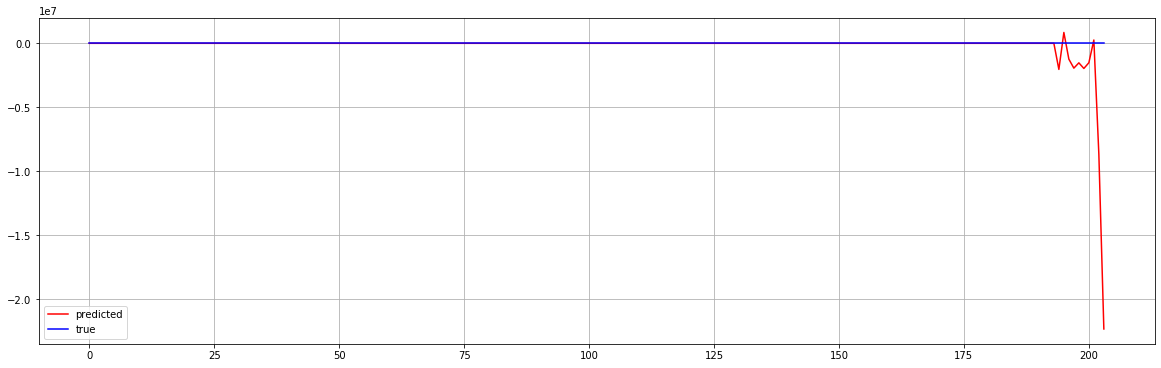

In [75]:
plt.figure(figsize=(20, 6))
plt.plot(preds, color='red', label='predicted')
plt.plot(y_val, color='blue', label='true')
plt.legend()
plt.grid()
plt.show()